<font size = 6>DNN solution to multi-period portfolio optimization - AR(1) case</font>
<font size = 4><div style="text-align: right"> Contributor: Haochen Jiang</div></font>
<font size = 4><div style="text-align: right"> Dec 5, 2022</div></font>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from numpy.random import multivariate_normal as mn
from cvxopt import matrix, solvers
from keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers
from sympy import Matrix
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
def state_trans(x, Rf):
    # auxiliary function of make_model function
    return (K.sum(x[0] * x[1], axis = 1, keepdims = True) + Rf + 1) * x[2]


def adjust_constraint(x, box):
    # auxiliary function of make_model function
    range = box[1] - box[0]
    multi_coef = range / 2
    add_coef = box[0] + multi_coef
    return x * multi_coef + add_coef


def get_layer_output(model, layer_name, input):
    layer_output = model.get_layer(layer_name).output
    intermediate_model = keras.models.Model(inputs = model.input, outputs = layer_output)
    intermediate_prediction=intermediate_model.predict(input)
    return intermediate_prediction


def make_model(v, t, p, box, Rf):
    # Numebr of hidden layers in each step / subnetwork equals to 2.
    x = keras.Input(shape = (1,), name = "W_0")
    w = x
    inputs, ws = [w], []

    for i in range(t):
        x = layers.Dense(units = v, name = "L_" + str(i) + "_1", kernel_initializer = "glorot_uniform", bias_initializer = "glorot_uniform")(x)
        x = layers.Dense(units = v, name = "L_" + str(i) + "_2", kernel_initializer = "glorot_uniform", bias_initializer = "glorot_uniform")(x)
        x = layers.Dense(units = p, activation = "tanh", name = "tanh_" + str(i), kernel_initializer = "glorot_uniform", bias_initializer = "glorot_uniform")(x)

        x = layers.Lambda(adjust_constraint, name = "g_" + str(i) , arguments = {"box" : box})(x) 
        input = keras.layers.Input(shape=(p, ), name = "Rk_" + str(i))
        x = layers.Lambda(state_trans, name = "W_" + str(i + 1), arguments = {"Rf" : Rf})([x, input, w]) 
        w = x

        inputs.append(input)
        ws.append(w)
    
    outputs = x
    return keras.Model(inputs, outputs)

# AR(1) Model

## Prepare the parameters

In [ ]:
# Number of risk assets
p_2 = 30
# Number of time period
t_2 = 10
# box constraints
box_2_1, box_2_2, box_2_3 = [0, 0.5], [0, 1], [-0.5, 0.5]

In [ ]:
# Mean vector of epsilons
mean_vec_2 = np.array([0] * p_2)
# Covariance matrix of epsilons
cov_matrix_2 = np.ones((p_2, p_2)) * 0.0027
cov_matrix_2 += np.diag([0.0238 - 0.0027] * p_2)
# Alpha vector of AR(1) model
alpha_vec_2 = np.array([0.015] * p_2)
# A matrix of AR(1) model
A = np.diag([-0.15] * p_2)

In [ ]:
# Check the parameters
#Matrix(mean_vec_2)
#Matrix(cov_matrix_2)
#Matrix(alpha_vec_2)
#Matrix(A)

## Prepare the functions

In [ ]:
def generate_input_output_2(port_num, samples, times, gamma, mean_vec = mean_vec_2, cov_matrix = cov_matrix_2, alpha_vec = alpha_vec_2, w_0 = 1, A = A, Rf = 0.03):
    p, n, t = port_num, samples, times
    # Since we have to calculate R_{-1} to R_{29} in this case
    # There are totally 31 elements in R, whose index is from 0 to 30, which are the subscripts plus 1
    Rs = [np.dot(np.linalg.inv(np.diag([1.15] * p)), alpha_vec)]
    random_matrix = mn(mean_vec, cov_matrix, t * n).reshape(t, n, p)
    for i in range(t):
        Rs.append(alpha_vec + np.dot(Rs[-1], A) + random_matrix[i])
    Rs = Rs[1:]
    output = np.array([[gamma / 2] * n]).T
    input = [np.array([[w_0] * n]).T]
    for R in Rs:
        input.append(R)
    return input, output


def train_model_2(v, port_num, samples, times, steps, gamma, box, get_weights = False): 
    p, n, t, s = port_num, samples, times, steps

    m = make_model(v = v, t = t, p = p, box = box, Rf = 0.03)
    m.compile(
        optimizer = keras.optimizers.Adam(learning_rate = 0.001),
        loss = tf.keras.losses.MeanSquaredError())
    
    c, d = generate_input_output_2(p, n, t, gamma)
    val_losses = []

    for _ in range(1, s + 1):
        a, b = generate_input_output_2(p, n, t, gamma)
        h = m.fit(x = a,  y = b, batch_size = 64, epochs=1, validation_data = [c, d], verbose = 1)
        val_losses.append(h.history["val_loss"][0])
    
    w_final = get_layer_output(m, "W_" + str(t), c).flatten()
    if get_weights:
        weights = []
        for i in range(t):
            weights.append(get_layer_output(m, "g_" + str(i), c))
        return m, np.sort(w_final), np.array(weights)
    else:
        return m, np.sort(w_final)

In [ ]:
def single_AR(port_num, samples, times, mu, if_cons = [0,1], external_rn = False, Rf = 0.03):
    p, n, t = port_num, samples, times 
    
    if external_rn:
        Rs = np.array(external_rn)
    else:
        Rs = np.array(generate_input_output_2(p, n, t, 0)[0][1:])

    R0 = Rs[0]
    cov_matrix_R0 = np.cov(np.array(R0.T))
    if if_cons != False:
        if type(if_cons) != list:
            raise Exception("Box constraints expressed by list is required!")
        # Since the default tolerances may be too strict if the problem is poorly conditioned
        # Modifying the constraints is not suggested here!
        l, u = if_cons
        g0s, ws = [], []
        for n_th in range(Rs.shape[1]):
            w = [1]
            P = matrix(cov_matrix_R0, tc='d')
            q = matrix(np.array([0] * p), tc='d')
            G = matrix(np.append(np.diag([-1] * p), np.diag([1] * p), axis=0), tc='d')
            h = matrix(np.array([l] * p + [u] * p), tc='d')
            A = matrix(np.array([R0[n_th]]), tc='d')
            b = matrix(np.array([mu - Rf]), tc='d')
            
            solvers.options['show_progress'] = False
            solvers.options['abstol'] = 1e-7
            solvers.options['reltol'] = 1e-6
            solvers.options['feastol'] = 1e-7
            #solvers.options['abstol'] = 1e-1
            #solvers.options['reltol'] = 1e-1
            #solvers.options['feastol'] = 1e-1

            try:
                sol = solvers.qp(P,q,G,h,A,b)
            except:
                break
            g0 = np.array(sol["x"]).flatten()
            for i in range(t):
                w.append(w[-1] * (np.dot(g0, Rs[i][n_th]) + Rf + 1))
            g0s.append(g0)
            ws.append(w)
        g0s = np.array(g0s)
        ws = np.array(ws).T
    else:
        ws = [1]
        denominator = np.diag(np.dot(np.dot(R0, np.linalg.inv(cov_matrix_R0)), R0.T))
        for i in range(t):
            ws.append(ws[-1] * ((mu - Rf) * np.diag(np.dot(np.dot(R0, np.linalg.inv(cov_matrix_R0)), Rs[i].T)) / denominator + Rf + 1))
        g0s = (mu - Rf) * np.dot(R0, np.linalg.inv(cov_matrix_R0)) / np.repeat(np.array([denominator]).T, p, axis=1)
        ws[0] = np.array([1] * n)
        ws = np.array(ws)
    return g0s, ws


def cal_single_AR(port_num, times, samples, mu_vec, if_cons, iter_num = 1):
    p, t, n = port_num, times, samples

    cal_single = pd.DataFrame(np.zeros((mu_vec.shape[0], 4)), index = mu_vec, columns = ["mean", "std", "label", "bias_num"])
    cal_single["label"].iloc[:] = ""

    for _ in range(iter_num):
        mean, std, label, bias_num = [], [], [], []
        for mu in mu_vec:
            temp = single_AR(p, n, t, mu = mu, if_cons = if_cons, external_rn = False)
            try:
                mean.append(temp[1][-1].mean())
                std.append(temp[1][-1].std())
                if temp[1].shape[1] == n:
                    label.append("Full")
                    bias_num.append(n - temp[1].shape[1])
                else:
                    label.append("Biased")
                    bias_num.append(n - temp[1].shape[1])
            except:
                mean.append(0)
                std.append(0)
                label.append("Empty")
                bias_num.append(n)
        cal_single["mean"] += mean
        cal_single["std"] += std
        if _ == 0:
            cal_single["label"] = label
            cal_single["bias_num"] = bias_num

    cal_single["std"] = cal_single["std"] / iter_num
    cal_single["mean"] = cal_single["mean"] / iter_num
    cal_single["mean"] = cal_single["mean"] - 1
    return cal_single

In [ ]:
def cal_multi_AR(v, port_num, times, box, gamma_vec, steps, samples):
    p, t, s, n = port_num, times, steps, samples

    cal_multi = pd.DataFrame(np.zeros((gamma_vec.shape[0], 2)), index = gamma_vec, columns = ["mean", "std"])
    mean, std = [], []
    for gamma in gamma_vec:
        temp = train_model_2(v, p, n, t, s, gamma, box)[1]
        mean.append(temp.mean())
        std.append(temp.std())
    cal_multi["mean"] += mean
    cal_multi["std"] += std
    cal_multi["mean"] = cal_multi["mean"] - 1

    return cal_multi

## Train Models

In [ ]:
#  multi_AR1 = cal_multi_AR(50, p_2, t_2, box_2_2, np.arange(3, 4.6, 0.2), steps = 100, samples = 10000)
#  multi_AR2 = cal_multi_AR(50, p_2, t_2, box_2_2, np.arange(4.6, 6, 0.2), steps = 100, samples = 10000)
#  multi_AR3 = cal_multi_AR(50, p_2, t_2, box_2_2, np.arange(6, 8, 0.2), steps = 150, samples = 10000)
#  multi_AR4 = cal_multi_AR(50, p_2, t_2, box_2_2, np.arange(8, 15, 0.2), steps = 150, samples = 10000)
multi_AR = pd.read_csv("multi_AR.csv", index_col = "Gamma")
multi_AR["std"].iloc[38] = multi_AR["std"].iloc[37]
multi_AR["mean"].iloc[38] = multi_AR["mean"].iloc[37]

In [ ]:
single_AR_con = cal_single_AR(p_2, t_2, 100, np.arange(0.03, 0.5, 0.01), [0, 1])
single_AR_no = cal_single_AR(p_2, t_2, 100, np.arange(0.03, 1, 0.01), False)

## Show Results

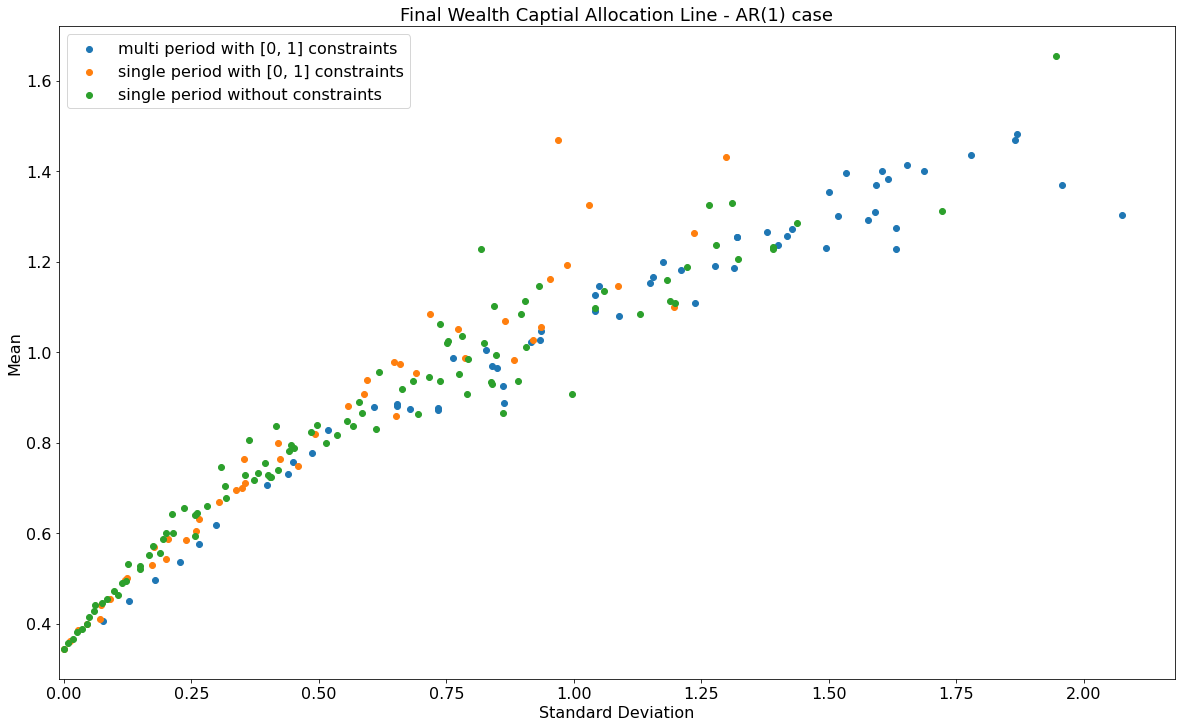

In [ ]:
fig =  plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(multi_AR["std"], multi_AR["mean"], label = "multi period with [0, 1] constraints")
ax.scatter(single_AR_con["std"], single_AR_con["mean"], label = "single period with [0, 1] constraints")
ax.scatter(single_AR_no["std"], single_AR_no["mean"], label = "single period without constraints")
plt.xlabel("Standard Deviation", fontsize = 16)
plt.ylabel("Mean", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
xlim = ax.get_xlim()
ax.set_xlim(-0.01, xlim[1])
plt.title("Final Wealth Captial Allocation Line - AR(1) case", fontsize = 18);